<a href="https://colab.research.google.com/github/BobZhang26/XAI-adversarial-patch/blob/main/AIPI_590_XAI_%7C_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment # 2
### Description
### Bob Zhang

#### Include the button below. Change the link to the location in your github repository:


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/templates/template.ipynb)

In [2]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI-adversarial-patch" # Change to your repo name
git_path = 'https://github.com/BobZhang26/XAI-adversarial-patch.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment-2'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'XAI-adversarial-patch'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 1), reused 17 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 8.05 KiB | 8.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [4]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-4-9bb6122fd041>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


### 1.Load the dataset

In [5]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


In [6]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 91.5MB/s]


In [7]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# print out random 10 names from label_names
import random
random.seed(42)
chosen_labels = random.sample(label_names, 10)
print(chosen_labels)

['minibus', 'slug', 'European fire salamander', 'reflex camera', 'tabby', 'Siberian husky', 'komondor', 'dowitcher', 'radio', 'wallaby']


### Define patch attack function

In [9]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [10]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [11]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [12]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [13]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [14]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [25]:
#class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
class_names = ["European fire salamander"]
patch_sizes = [64]#[32, 48, 64]

patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for European fire salamander and 64: {'acc': 0.9850000143051147, 'top5': 0.9990000128746033}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

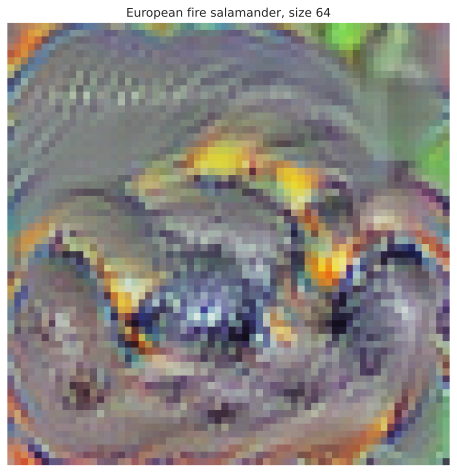

In [28]:
def show_patches():
    fig, ax = plt.subplots(figsize=(8, 8))
    patch = patch_dict[class_names[0]][patch_sizes[0]]["patch"]
    patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()
    patch = np.clip(patch, a_min=0.0, a_max=1.0)
    ax.imshow(patch)
    ax.set_title(f"{class_names[0]}, size {patch_sizes[0]}")
    ax.axis('off')
    plt.show()
show_patches()